# Time Series (ARIMA)

---
<a name="0"/>

### Зміст:

* [1. Підготовка](#1)
* [2. Імпорт данних](#2)
* [3. Первинний аналіз](#3)
* [4. Вторинний аналіз (нормальність, стаціонарність, тести)](#4)
* [5. Побудова моделі](#5)
* [6. Аналіз і оцінка моделі](#6)
* [7. Прогноз](#7)

---
<a name="1"/>

### 1. Підготовка

[зміст](#0)

Імпорт бібліотек

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

Налаштування

In [5]:
sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

---
<a name="2"/>

### 2. Імпорт данних
[зміст](#0)

In [6]:
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1139&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=T10Y2Y&scale=left&cosd=2018-08-17&coed=2023-08-17&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-08-18&revision_date=2023-08-18&nd=1976-06-01'

In [9]:
resp = urlopen(url)
data = pd.read_csv(resp, delimiter=',')
    
data.head()

,DATE,T10Y2Y
0,2018-08-17,0.26
1,2018-08-20,0.22
2,2018-08-21,0.24
3,2018-08-22,0.22
4,2018-08-23,0.21


Бачимо 2 фічі. Перша - часовий ряд, друга цількісна, дробова.

---
<a name="3"/>

### 3. Первинний аналіз
[зміст](#0)

Перевірка дублікатів

In [10]:
data.duplicated().sum()

0

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1305 non-null   object
 1   T10Y2Y  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


Потрібно перетворити `DATE` в datetime формат, а `T10Y2Y` в float

In [12]:
data.describe()

,DATE,T10Y2Y
count,1305,1305
unique,1305,250
top,2018-08-17,.
freq,1,55


Бачимо в фічі `T10Y2Y` значення `.`, це явні пропуски. Потрібно їх замінити.

Перетворимо `DATE`  в `datetime` формат

In [13]:
data['DATE'] = pd.to_datetime(data['DATE'])

Заміними всі `.` значень в  `T10Y2Y` на `NaN`

In [14]:
data = data.replace(['.'], np.nan)

In [15]:
data.isnull().sum()

DATE       0
T10Y2Y    55
dtype: int64

Заміними всі пропущєні значеня на попепедні

In [16]:
data['T10Y2Y'] = data['T10Y2Y'].fillna(method='ffill')

In [17]:
data.isnull().sum()

DATE      0
T10Y2Y    0
dtype: int64

Змінимо формат данних `T10Y2Y` на `float16`

In [18]:
data['T10Y2Y'] = data['T10Y2Y'].astype('float16')

Перетворимо фічу `DATE` в `Index`

In [19]:
data = data.set_index('DATE')

Побудуємо графі данних

<Axes: xlabel='DATE'>

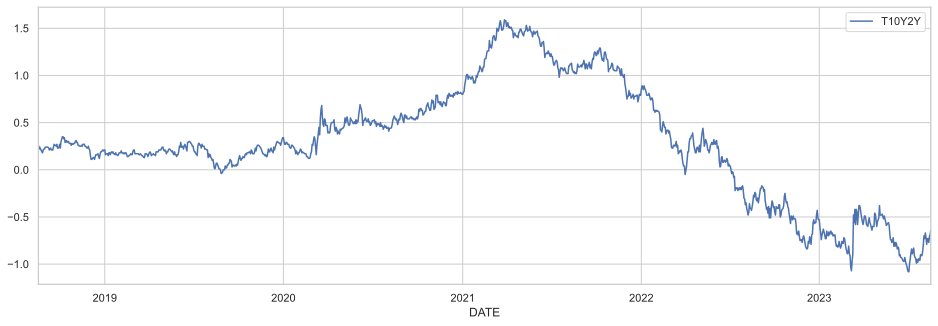

In [20]:
data.plot(figsize=(16,5))

Дивлячись на графік бачимо що є тенденція і, можливо сезонність. Зробимо декомпозицію STL щоб краще зрозуміти.

---
<a name="4"/>

### 4. Вторинний аналіз (нормальність, стаціонарність, тести)
[зміст](#0)

Перейдемо к недільному інтервалу для того щоб згладити графік та позбутися викидів.

In [21]:
data = data.resample('W').mean()

---

## Нормальність росподілу

Тест Харкі — Бера

In [22]:
def harki_bera_test(series):
    jb_test = sm.stats.stattools.jarque_bera(series)
    a = np.vstack([jb_test])
    print('p-value: %f' % a[1])

In [23]:
harki_bera_test(data)

p-value: 0.313877


Значення даної статистика свідчить про те, нульова гіпотеза про нормальність розподілу відкидається (probably > 0.05), і, отже, наш ряд має нормальний розподіл

---

## Стаціонарність

Діккі-Фуллера

In [24]:
def dikki_fuller_test(series):
    test = sm.tsa.adfuller(series)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']:
        print('є одиничні корені, ряд не стаціонарний')
    else:
        print('одиничних коренів немає, ряд стаціонарний')

In [25]:
dikki_fuller_test(data)

adf:  -0.5735694129518036
p-value:  0.8768431186981548
Critical values:  {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
є одиничні корені, ряд не стаціонарний


Візьмемо разність рядів. Період інтегрування - 2.

In [26]:
data1diff = data.diff(periods=2).dropna()

In [27]:
dikki_fuller_test(data1diff)

adf:  -4.032135693365686
p-value:  0.0012512787538219486
Critical values:  {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
одиничних коренів немає, ряд стаціонарний


Перший порядок інтегрованого ряду стаціонарний.

Для повної впевненості розіб'ємо його на кілька проміжків і переконаємося мат. очікування на різних інтервалах:

In [28]:
def math_exp(diff_series):
    m = diff_series.index[len(diff_series.index)//2+1]
    print(m)
    r1 = sm.stats.DescrStatsW(diff_series[m:])
    r2 = sm.stats.DescrStatsW(diff_series[:m])
    print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

In [29]:
math_exp(data1diff)

2021-03-07 00:00:00
p-value:  [0.00023501]


Переконаємось в стаціонарності ряду

<Axes: xlabel='DATE'>

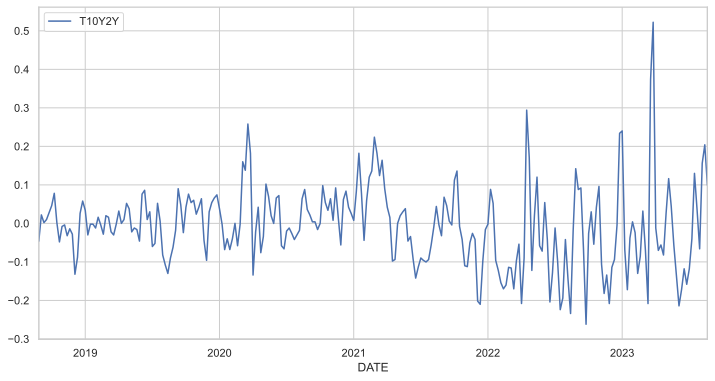

In [30]:
data1diff.plot(figsize=(12,6))

Тренд справді відсутній, таким чином ряд перших різниць є стаціонарним, а наш вихідний ряд - інтегрованим рядом другого порядку

Декомпозиція STL

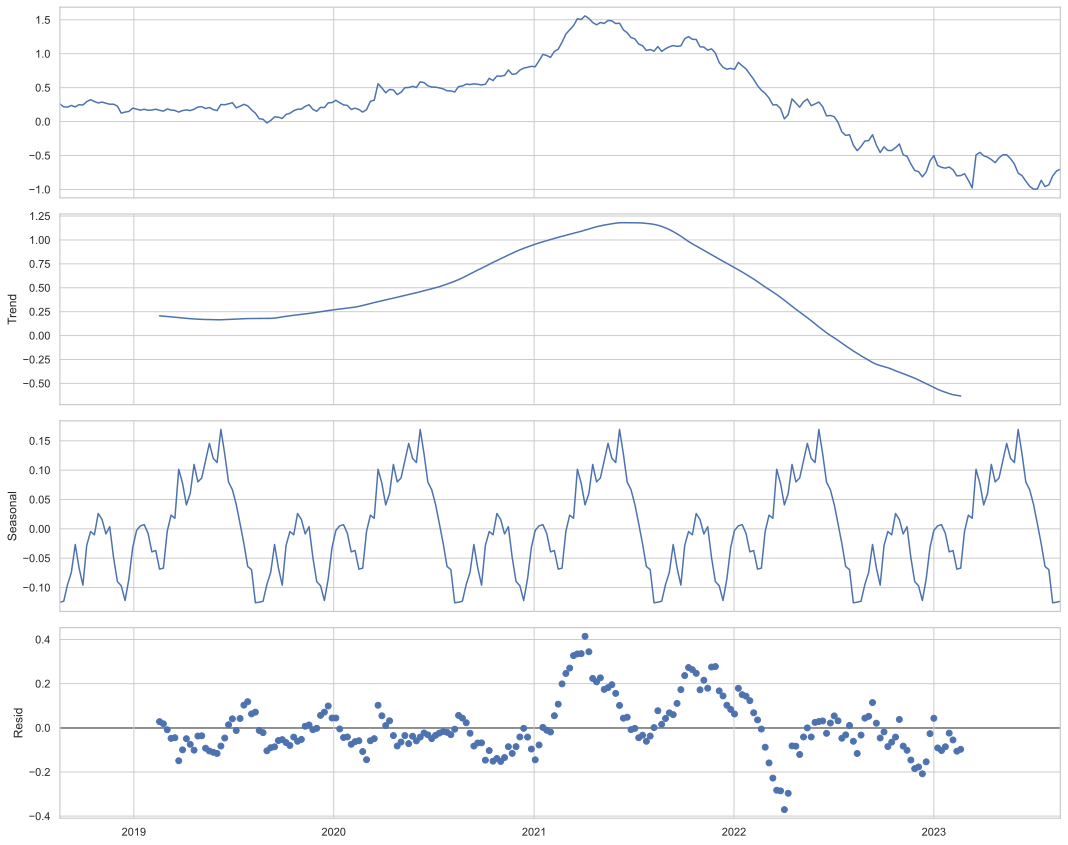

In [31]:
plt.rc( 'figure' ,figsize=(15 , 12))
plt.rc( 'font' ,size= 15 )

result = seasonal_decompose(data, model= 'additive' )
fig = result.plot()

Добре видно тенденцію, спочатку на зростання, а потім на зменьшення. Коливання сезонності тут приблизно 12 місяцні.

---

## Графіки ACF і PACF

Подивимося на графіки `ACF` і `PACF`, щоб отримати уявлення про значення `p` і `q`

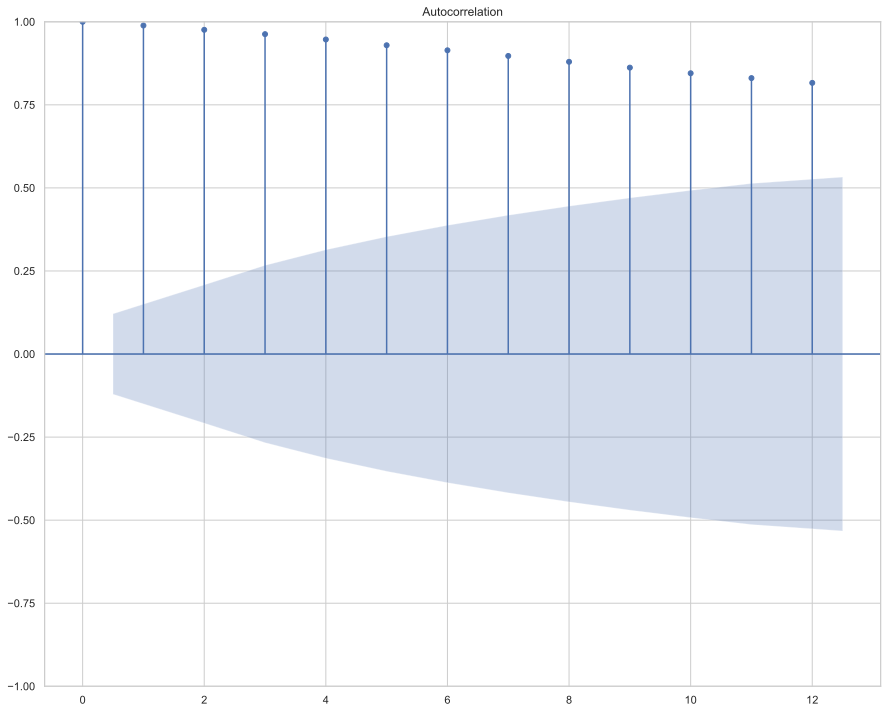

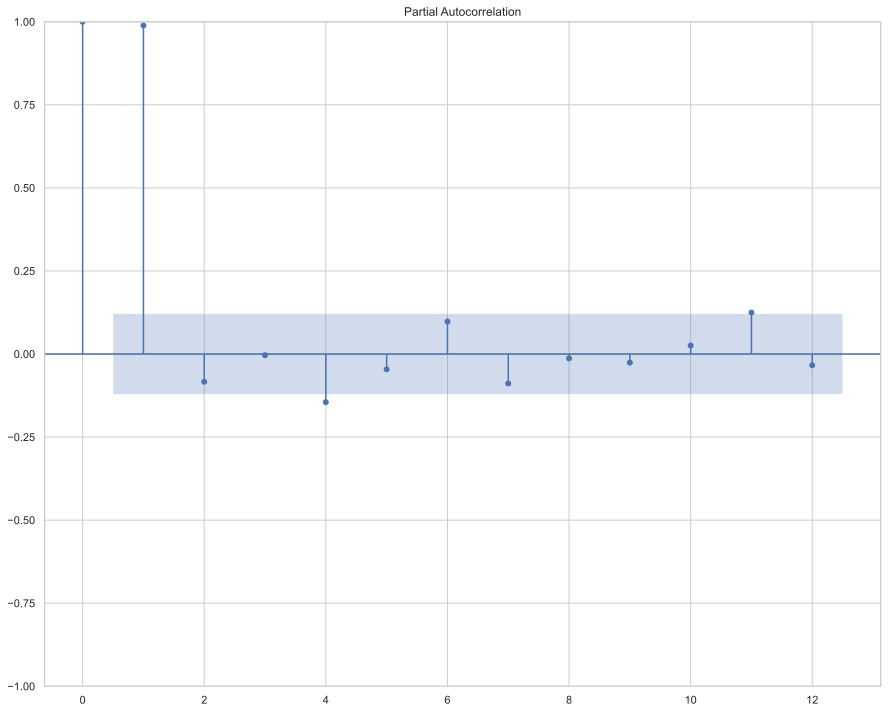

In [32]:
plot_acf(data, lags= 12);
plot_pacf(data, lags= 12 );

Виходячи з графіків оберемо коефіцієнти `p = 1` та `q = 1`

---
<a name="5"/>

### 5. Побудова ARIMA моделі з обраними параметрами

[зміст](#0)

In [33]:
src_data_model = data[:'2023-01-01']
model = ARIMA(src_data_model, order=(1,2,1), freq='W').fit()

In [34]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  229
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 316.592
Date:                Fri, 18 Aug 2023   AIC                           -627.185
Time:                        15:14:40   BIC                           -616.910
Sample:                    08-19-2018   HQIC                          -623.039
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1257      0.056      2.229      0.026       0.015       0.236
ma.L1         -0.9635      0.015    -63.651      0.000      -0.993      -0.934
sigma2         0.0036      0.000     13.772      0.0

Як видно з цієї інформації, у нашій моделі всі коефіцієнти значущі й можна перейти до оцінки моделі.

---
<a name="6"/>

### 6. Аналіз і оцінка моделі

[зміст](#0)

In [35]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) # властивість resid, зберігає залишки моделі, qstat=True, означає, що застосовуємо вказаний тест до коеф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.714280  0.398027
1    1.264717  0.531337
2    6.379646  0.094532
3    6.464557  0.167037
4   11.118255  0.049085
5   11.153977  0.083733
6   11.249960  0.128081
7   11.249998  0.187932
8   11.271567  0.257553
9   13.205011  0.212434
10  13.818982  0.243172
11  13.988862  0.301420
12  15.510113  0.276598
13  15.668243  0.334051
14  16.665879  0.339227
15  20.049139  0.218016
16  20.871890  0.232073
17  21.841805  0.239084
18  22.239592  0.272495
19  22.243639  0.327438
20  26.194266  0.199138
21  26.253939  0.240939
22  27.755686  0.225162


Значення цієї статистики і p-values свідчать про те, що гіпотеза про випадковість залишків не відкидається, і, найімовірніше, цей процес являє собою "білий шум".

Тепер давайте розрахуємо коефіцієнт детермінації `R^2`, щоб зрозуміти який відсоток спостережень описує ця модель

In [37]:
pred = model.predict('2023-01-01', '2024-01-01', typ='levels')
trn = data['2023-01-01':]
r2 = r2_score(trn, pred[1:35])
print( 'R^2: %1.2f' % r2)

R^2: -0.24


Середньоквадратичне відхилення нашої моделі

In [39]:
mean_squared_error(trn, pred[1:35], squared=False)

0.1861820250519484

Середня абсолютна помилка прогнозу:

In [40]:
mean_absolute_error(trn, pred[1:35])

0.1618826216526553

---
<a name="7"/>

### 7. Прогноз

[зміст](#0)

Малюємо прогноз на графіку

<Axes: xlabel='DATE'>

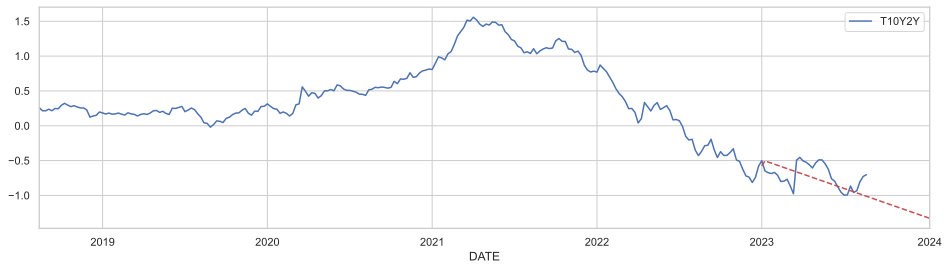

In [41]:
data.plot(figsize=(16,4))
pred.plot(style='r--')

З графіку видно лінійний предикт, у котрого нахил в сторону зменьшення тенденції.

### Дякую за увагу =)